In [44]:
from data import get_hf_image_dataset, image_transform
from model import UIL
import matplotlib.pyplot as plt
import data
import torch
import numpy as np
from flax.training import checkpoints

In [337]:
preprocess_train = image_transform(224, is_train=True)
train_loader = get_hf_image_dataset(
        data='imagenet-1k',
        split='validation',
        preprocess_fn=preprocess_train,
        batch_size=256,
        num_workers=0,
        image_key='image',
        label_key='label',
    )
in1k = train_loader.dataset
oai_mu = np.array(data.OPENAI_DATASET_MEAN)
oai_sd = np.array(data.OPENAI_DATASET_STD)

In [338]:
batch = next(iter(train_loader))

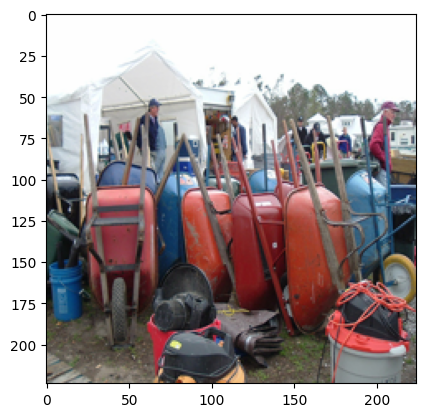

In [339]:
z = (batch['image'].permute(0, 2, 3, 1) * oai_sd) + oai_mu

plt.imshow(z[25])

In [340]:
model_config = dict(
        image_size=224,
        patch_size=16,
        width=768,
        layers=12,
        heads=12,
        noise_std=0.8,
        mask_ratio=0.75,
        decoder_layers=8,
        decoder_width=512,
        decoder_heads=16,
        dropout_rate=0,
        attn_dropout_rate=0,
        do_denoise=True,
        do_mae=True,
        do_causal=True,
    )

model = UIL(**model_config, deterministic=True)

ckpt = checkpoints.restore_checkpoint('checkpoints/pretrain/imagenet_all_5e/checkpoints', target=None)
params = ckpt['params']

In [341]:
import jax.numpy as jnp
import jax

images = jnp.array(batch['image'].permute(0, 2, 3, 1))
rng = jax.random.PRNGKey(0)

In [342]:
pred_mae, pred_causal, mask, pred_noise, noise = UIL(
    **model_config, 
    deterministic=True).apply(
            {'params': params},
            images, rng,
        )

In [343]:
def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = 16
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
        
    x = x.reshape((x.shape[0], h, w, p, p, 3))
    x = jnp.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape((x.shape[0], 3, h * p, h * p))
    return imgs

In [344]:
pred = unpatchify(pred_mae).transpose((0, 2, 3, 1))
mask_hat = jnp.tile(mask[..., None], 16**2*3)  # (N, H*W, p*p*3)
patch_mask = unpatchify(mask_hat).transpose(0, 2, 3, 1)

In [345]:
pred_c = unpatchify(pred_causal).transpose((0, 2, 3, 1))

In [346]:
c_mask = np.zeros_like(mask)
c_mask[:, :int(pred_causal.shape[1] * 0.25)] = 1
c_mask = jnp.tile(c_mask[..., None], 16**2*3)
c_mask = unpatchify(c_mask).transpose(0, 2, 3, 1)

In [347]:
pred_n = unpatchify(pred_noise).transpose((0, 2, 3, 1))
perturbed = (images + noise)

In [348]:
pred_d = (perturbed - pred_n)

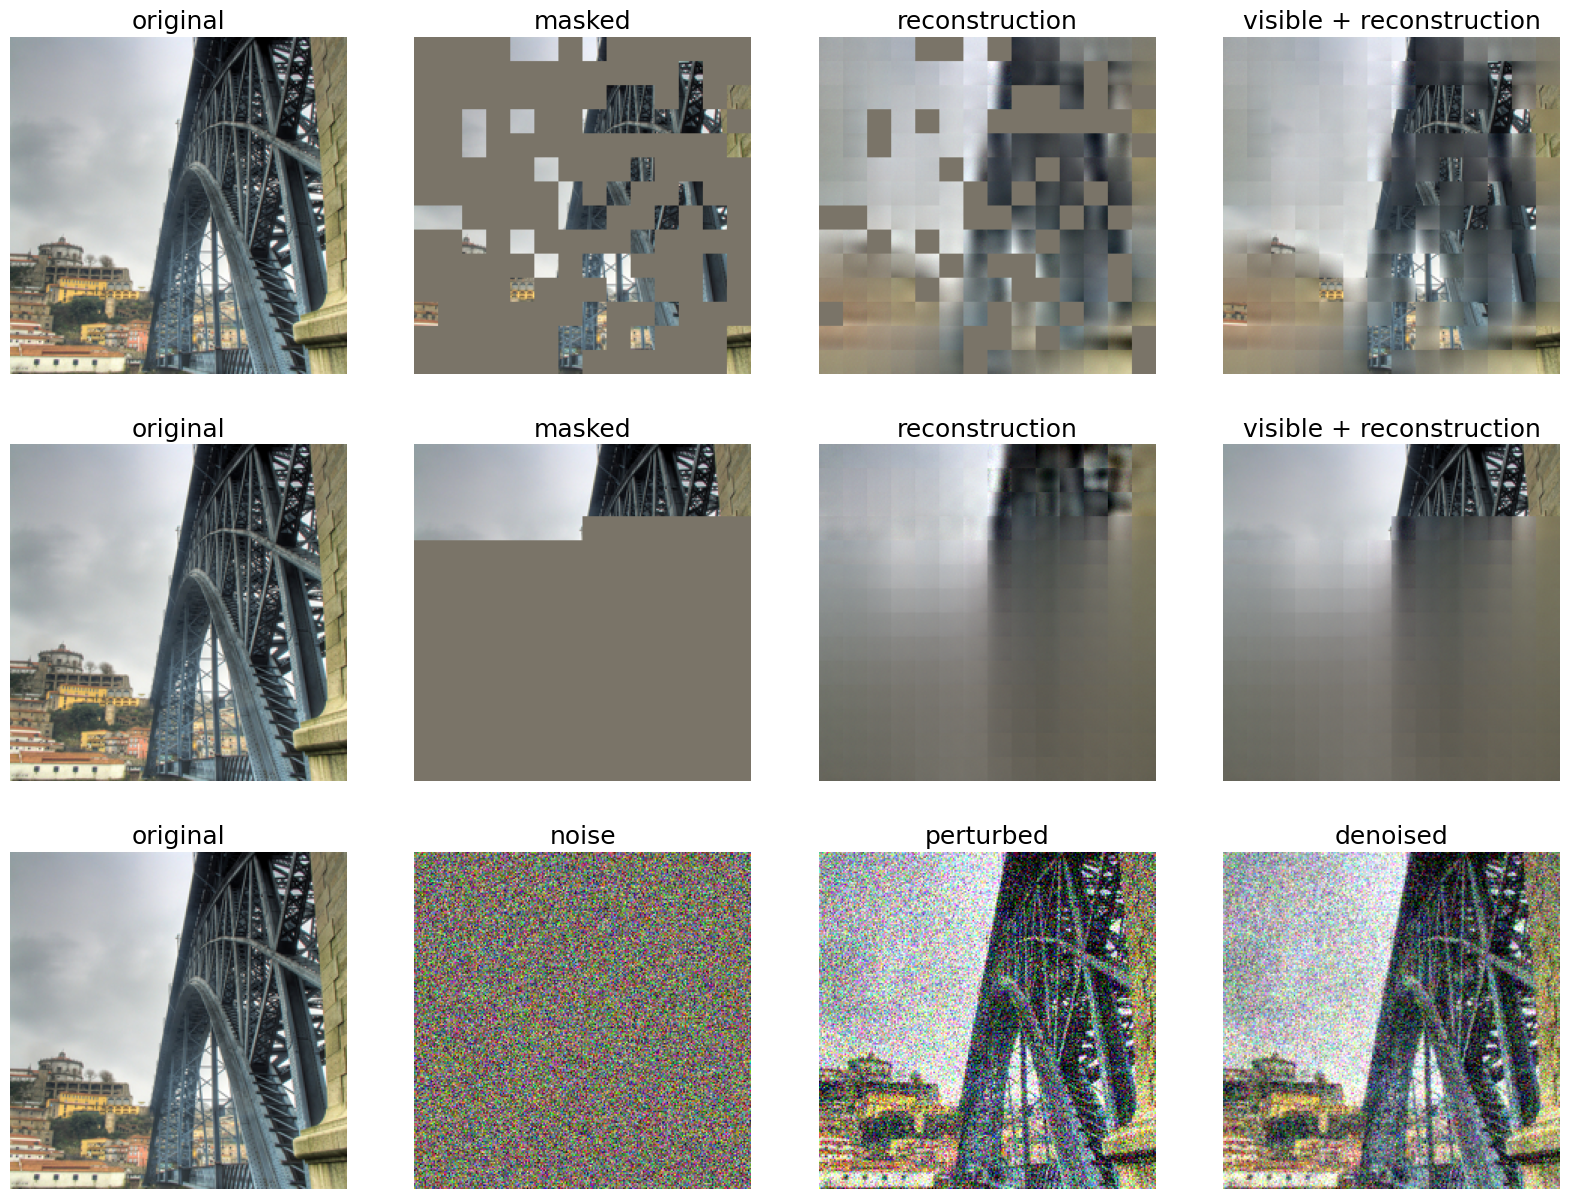

In [406]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# good idx: 2, 3
idx = 78

for r in range(3):
    for i in range(4):
        axes[r][i].axis('off')

axes[0][0].imshow(images[idx] * oai_sd + oai_mu)
axes[0][0].set_title('original', fontsize=18)
axes[0][1].imshow(((1 - patch_mask) * images)[idx] * oai_sd + oai_mu)
axes[0][1].set_title('masked', fontsize=18)
axes[0][2].imshow((patch_mask * pred)[idx] * oai_sd + oai_mu)
axes[0][2].set_title('reconstruction', fontsize=18)
axes[0][3].imshow(((1 - patch_mask) * images + patch_mask * pred)[idx] * oai_sd + oai_mu)
axes[0][3].set_title('visible + reconstruction', fontsize=18)

axes[1][0].imshow(images[idx] * oai_sd + oai_mu)
axes[1][0].set_title('original', fontsize=18)
axes[1][1].imshow((c_mask * images)[idx] * oai_sd + oai_mu)
axes[1][1].set_title('masked', fontsize=18)
axes[1][2].imshow(pred_c[idx] * oai_sd + oai_mu)
axes[1][2].set_title('reconstruction', fontsize=18)
axes[1][3].imshow(((c_mask) * images + (1-c_mask) * pred_c)[idx] * oai_sd + oai_mu)
axes[1][3].set_title('visible + reconstruction', fontsize=18)

axes[2][0].imshow(images[idx] * oai_sd + oai_mu)
axes[2][0].set_title('original', fontsize=18)
axes[2][1].imshow(noise[idx] * oai_sd + oai_mu)
axes[2][1].set_title('noise', fontsize=18)
axes[2][2].imshow(perturbed[idx] * oai_sd + oai_mu)
axes[2][2].set_title('perturbed', fontsize=18)
axes[2][3].imshow(pred_d[idx] * oai_sd + oai_mu)
axes[2][3].set_title('denoised', fontsize=18)

plt.show()

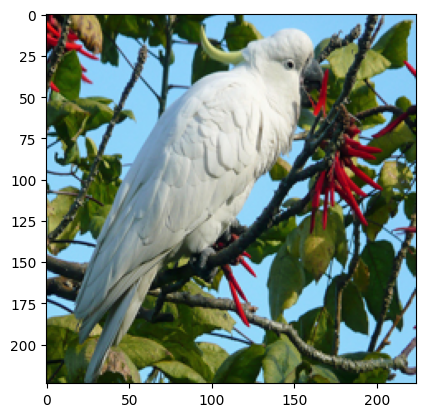

In [399]:
plt.imshow(images[72] * oai_sd + oai_mu)

In [335]:
len(images)

32